# Setup

In [1]:
# mount drive 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd "/content/gdrive/My Drive/Github/SubjectIndexing"

/content/gdrive/My Drive/Github/SubjectIndexing


In [3]:
# general
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PCA for plotting 
from sklearn.decomposition import PCA

# custom library for transformers
from src.utils.embeddings import Book2Vec

# Create Embeddings

In [4]:
# import dataset
df = pd.read_json('./data/dataset_B.json')

In [6]:
# calculate embeddings module 
#book2vec = Book2Vec(tokenizer='allenai/longformer-base-4096', model='allenai/longformer-base-4096')
#X_embeddings = book2vec.get_embeddings(df.X)
#Book2Vec.save_embeddings(X_embeddings, './work/embeddings_classB_last4layers.pkl')
X_embeddings = Book2Vec.load_embeddings('./work/embeddings_classB_last4layers.pkl')

# Plot 

In [9]:
# conduct PCA for graphical representation
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(X_embeddings)
print(pca.explained_variance_ratio_.sum())

0.3827322


In [10]:
df['2d_x'] = embeddings_2d[:,0]
df['2d_y'] = embeddings_2d[:,1]

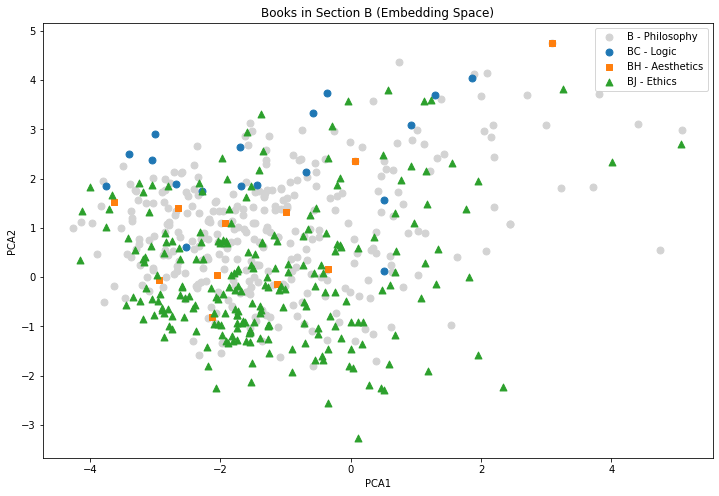

In [11]:
plt.figure(figsize=(12,8))
plt.scatter(df[df['y'] == 'B']['2d_x'], df[df['y'] == 'B']['2d_y'], c='lightgrey', s=48, label='B - Philosophy')
plt.scatter(df[df['y'] == 'BC']['2d_x'], df[df['y'] == 'BC']['2d_y'], c='tab:blue', s=48, label='BC - Logic')
plt.scatter(df[df['y'] == 'BH']['2d_x'], df[df['y'] == 'BH']['2d_y'], c='tab:orange', s=48, marker='s',label='BH - Aesthetics')
plt.scatter(df[df['y'] == 'BJ']['2d_x'], df[df['y'] == 'BJ']['2d_y'], c='tab:green', s=48, marker='^', label='BJ - Ethics')
#plt.scatter(df[df['y'] == 'BS']['2d_x'], df[df['y'] == 'BS']['2d_y'], c='tab:cyan', s=52, marker='^', label='BS - The Bible')
plt.title("Books in Section B (Embedding Space)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
#for i, txt in enumerate([str(x) for x in list(books_B.keys())]):
#    plt.annotate(txt, (embeddings_2d[:,0][i], embeddings_2d[:,1][i]))
plt.legend()
plt.show()

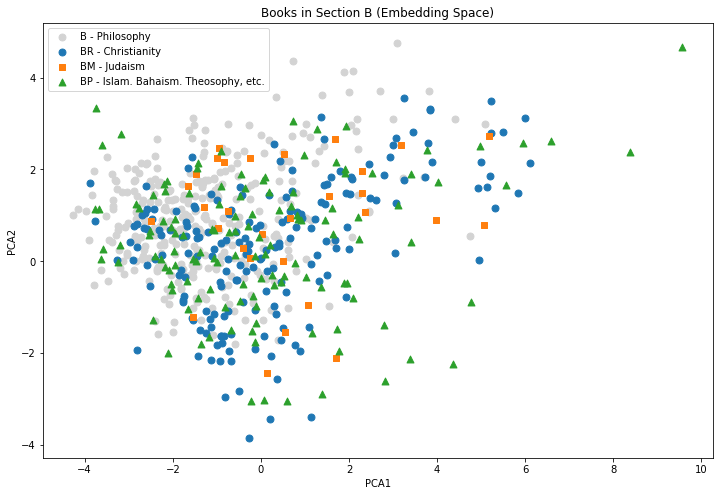

In [12]:
plt.figure(figsize=(12,8))
plt.scatter(df[df['y'] == 'B']['2d_x'], df[df['y'] == 'B']['2d_y'], c='lightgrey', s=48, label='B - Philosophy')
plt.scatter(df[df['y'] == 'BR']['2d_x'], df[df['y'] == 'BR']['2d_y'], c='tab:blue', s=48, label='BR - Christianity')
#plt.scatter(df[df['y'] == 'BS']['2d_x'], df[df['y'] == 'BS']['2d_y'], c='tab:blue', s=48, label='BS - The Bible')
#plt.scatter(df[df['y'] == 'BT']['2d_x'], df[df['y'] == 'BT']['2d_y'], c='tab:orange', s=48, marker='d', label='BT - Doctrinal Theology')
plt.scatter(df[df['y'] == 'BM']['2d_x'], df[df['y'] == 'BM']['2d_y'], c='tab:orange', s=48, marker='s', label='BM - Judaism')
plt.scatter(df[df['y'] == 'BP']['2d_x'], df[df['y'] == 'BP']['2d_y'], c='tab:green', s=48, marker='^', label='BP - Islam. Bahaism. Theosophy, etc.')
plt.title("Books in Section B (Embedding Space)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
#for i, txt in enumerate([str(x) for x in list(books_B.keys())]):
#    plt.annotate(txt, (embeddings_2d[:,0][i], embeddings_2d[:,1][i]))
plt.legend()
plt.show()

# Classification

In [13]:
# sklearn models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# sklearn utilities
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_embeddings, df.y, test_size=0.2, shuffle=True, random_state=0)

## Random Forest

In [15]:
start = time.time()
rf = RandomForestClassifier(n_estimators=500, max_depth=5, random_state=0)
rf_scores = cross_val_score(rf, X_train, y_train, cv=5)
print(np.mean(rf_scores))
end = time.time()
print("Runtime:", round((end-start)//60), "min",  round((end-start)%60), "sec")

0.522999298568254
Total runtime: 2 min 2 sec


## Gradient Boosting

In [ ]:
start = time.time()
gb = GradientBoostingClassifier(n_estimators=300, learning_rate=0.01, max_depth=5, random_state=0)
gb_scores = cross_val_score(gb, X_train, y_train, cv=5)
print(np.mean(gb_scores))
end = time.time()
print("Runtime:", round((end-start)//60), "min",  round((end-start)%60), "sec")

## SVM

In [ ]:
start = time.time()
svm = make_pipeline(StandardScaler(), SVC(C=10, gamma='scale', random_state=0))
svm_scores = cross_val_score(svm, X_train, y_train, cv=5)
print(np.mean(svm_scores))
end = time.time()
print("Runtime:", round((end-start)//60), "min",  round((end-start)%60), "sec")

## Neural Net

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
labels = sorted(list(set(y_train)))
class2label = {}
for i in range(len(labels)):
    class2label[labels[i]] = i
y_train_labels = [class2label[l] for l in y_train]
y_train_oh = to_categorical(y_train_labels)

In [ ]:
# model structure
input = tf.keras.Input(shape=(X_train.shape[1],))
x = tf.keras.layers.Dense(1024, activation='relu')(input)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
output = tf.keras.layers.Dense(len(set(labels)), activation='softmax')(x)
model = tf.keras.Model(inputs=input, outputs=output)

# compile model
model.compile(
    loss = 'sparse_categorical_crossentropy', 
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics = ['sparse_categorical_accuracy']]
)
model.summary()

In [ ]:
# train model
history = model.fit(
    X_train, y_train_labels, validation_split=0.2, shuffle=True,
    batch_size=256, epochs=50, verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, restore_best_weights=True)]
)

In [ ]:
# print training history
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))
plt.plot(epochs, acc, 'tab:red', label='Training Acc')
plt.plot(epochs, val_acc, 'tab:blue', label='Validation Acc')
plt.title('Training and validation Acc')
plt.legend()
plt.plot(epochs, loss, 'tab:red', label='Training Loss')
plt.plot(epochs, val_loss, 'tab:blue', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.show()